In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.68631697,  0.72730255, -0.00594355], dtype=float32)

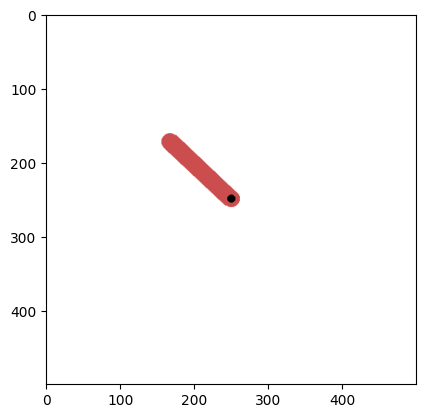

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch


class ModelAction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_state = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )
        self.fc_mu = torch.nn.Linear(128, 1)
        self.fc_std = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Softplus(),
        )

    def forward(self, state):
        #[b, 3] -> [b, 128]
        state = self.fc_state(state)

        #[b, 128] -> [b, 1]
        mu = self.fc_mu(state)

        #[b, 128] -> [b, 1]
        std = self.fc_std(state)

        #根据mu和std定义b个正态分布
        dist = torch.distributions.Normal(mu, std)

        #采样b个样本
        #这里用的是rsample,表示重采样,其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
        sample = dist.rsample()

        #样本压缩到-1,1之间,求动作
        action = torch.tanh(sample)

        #求概率对数
        log_prob = dist.log_prob(sample)

        #这个值描述动作的熵
        entropy = log_prob - (1 - action.tanh()**2 + 1e-7).log()
        entropy = -entropy

        return action * 2, entropy


model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[1.4742],
         [1.5290]], grad_fn=<MulBackward0>),
 tensor([[0.4182],
         [0.8354]], grad_fn=<NegBackward0>))

In [4]:
class ModelValue(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

    def forward(self, state, action):
        #[b, 3+1] -> [b, 4]
        state = torch.cat([state, action], dim=1)

        #[b, 4] -> [b, 1]
        return self.sequential(state)


model_value = ModelValue()
model_value_next = ModelValue()
model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 3), torch.randn(2, 1))

tensor([[-0.0656],
        [ 0.0050]], grad_fn=<AddmmBackward0>)

In [5]:
import random
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    action, _ = model_action(state)
    return action.item()


get_action([1, 2, 3])

-1.8301947116851807

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step([action])

        #记录数据样本
        datas.append((state, action, reward, next_state, over))

        #更新游戏状态,开始下一个动作
        state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 100000:
        datas.pop(0)


update_data()

len(datas), datas[0]

(200,
 (array([-0.7754088 , -0.6314596 , -0.01864797], dtype=float32),
  1.0557578802108765,
  -6.043692695096031,
  array([-0.7858418, -0.6184276, -0.333879 ], dtype=float32),
  False))

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_2372/1710091499.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-0.9537,  0.3007,  0.3416],
         [-0.9814, -0.1921, -0.1296],
         [-0.9942, -0.1071,  0.0899],
         [-0.9952, -0.0978,  0.0211],
         [-0.9945, -0.1048,  0.1593]]),
 tensor([[ 1.4174],
         [-1.7115],
         [ 1.5697],
         [ 0.2318],
         [-0.8715]]),
 tensor([[-8.0573],
         [-8.6968],
         [-9.2099],
         [-9.2640],
         [-9.2241]]),
 tensor([[-0.9647,  0.2633,  0.7798],
         [-0.9861, -0.1661, -0.5305],
         [-0.9929, -0.1193,  0.2450],
         [-0.9953, -0.0969, -0.0175],
         [-0.9948, -0.1023, -0.0501]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1337.0967746729043

In [9]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
def get_target(reward, next_state, over):
    #首先使用model_action计算动作和熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy = model_action(next_state)

    #评估next_state的价值
    #[b, 4],[b, 1] -> [b, 1]
    target = model_value_next(next_state, action)

    #这里的操作是在target上加上了动作的熵
    #[b, 1] - [b, 1] -> [b, 1]
    target += 0.005 * entropy

    #[b, 1]
    target *= 0.99
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [11]:
def get_loss_action(state):
    #计算action和熵
    #[b, 3] -> [b, 1],[b, 1]
    action, entropy = model_action(state)

    #使用value网络评估action的价值
    #[b, 3],[b, 1] -> [b, 1]
    value = model_value(state, action)

    #熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
    #[1] - [b, 1] -> [b, 1]
    loss_action = -0.005 * entropy

    #减去value,所以value越大越好,这样loss就会越小
    loss_action -= value

    return loss_action.mean()


get_loss_action(state)

tensor(-0.0040, grad_fn=<MeanBackward0>)

In [12]:
def train():
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=3e-4)
    optimizer_value = torch.optim.Adam(model_value.parameters(), lr=3e-3)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(100):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #对reward偏移,为了便于训练
            reward = (reward + 8) / 8

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            #计算value
            value = model_value(state, action)

            #计算loss,value的目标是要贴近target
            loss_value = loss_fn(value, target)

            #更新参数
            optimizer_value.zero_grad()
            loss_value.backward()
            optimizer_value.step()

            #使用model_value计算model_action的loss
            loss_action = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #增量更新next模型
            soft_update(model_value, model_value_next)

        if epoch % 10 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), test_result)


train()

0 400 -1661.8095294373827
10 2400 -1514.7647813052058
20 4400 -1575.5831378945663
30 6400 -662.5823267235334
40 8400 -986.4176449379411
50 10400 -998.4606477021243
60 12400 -370.6228748522011
70 14400 -225.43343732554158
80 16400 -142.0383754240294
90 18400 -321.4496607018651


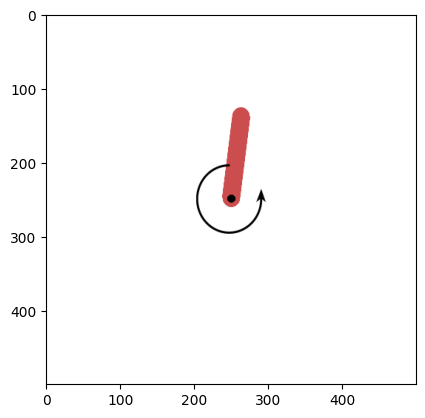

-230.40490074762405

In [13]:
test(play=True)